# Demographics

Demographics of ALL patients in database (regardless of if they have CPVT or not)

- Number of articles
- Number of patients
- Patients by sex
- Patients by variant zygosity
- Number of patients with CPVT phenotype
- Primary diagnosis of patients
- Number of variants (cDNA and protein level)
- Variants by type (missense, deletion, etc)

In [1]:
from typing import Literal

import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")

In [2]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_07"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

Creating directory: ../figures/0_3_1/analysis_07


In [3]:
colors = config.figure_palette

figure_2 = config.figure2
figure_3 = config.figure3


In [4]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def add_bar_labels(ax, fmt="{:.0f}", ignore_zero=True, direction="vertical"):
    for bar in ax.patches:

        if bar.get_height() == 0 and ignore_zero:
            continue

        if direction == "vertical":
            # Use ax.text() to add text over the bars
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    fmt.format(bar.get_height()),
                    ha='center', va='bottom')
            # add 1% to the height
            y_min, y_max = ax.get_ylim()
            ax.set_ylim(y_min, (y_max - y_min) * 0.01 + y_max)
        else:
            ax.text(bar.get_width() + 0.02 * bar.get_width(),
                    bar.get_y() + bar.get_height() / 2,
                    fmt.format(bar.get_width()),
                    ha='left', va='center')
            # add 1% to the width
            x_min, x_max = ax.get_xlim()
            ax.set_xlim(x_min, (x_max - x_min) * 0.01 + x_max)


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)

## Num Articles

In [6]:
num_articles = df["publication_id"].nunique()

num_total_articles = f"Number of articles: {num_articles}"
num_total_articles

'Number of articles: 221'

## Patients

In [7]:
num_patients = df["individual_id"].nunique()

num_total_patients = f"Number of patients: {num_patients}"
num_total_patients

'Number of patients: 1342'

In [8]:
def add_percent(df_input: pd.DataFrame | pd.Series, denom: Literal[
    "patients", "patient_variants", "variants"] = "patients"):
    if denom == "patients":
        denominator = num_patients
    elif denom == "patient_variants":
        denominator = len(df)
    elif denom == "variants":
        denominator = df["hgvs_string"].nunique()
    else:
        raise ValueError(f"Invalid denominator: {denom}")

    # if it's a series, convert to a dataframe
    if isinstance(df_input, pd.Series):
        df_input = df_input.to_frame()

    total_patients_report = df_input["count"].sum()
    df_input["percentage"] = (
            df_input["count"] / total_patients_report * 100).round(2)

    # get total out of num patients
    print(
        f"Total: {total_patients_report} {total_patients_report / denominator * 100:.2f}%")

    return df_input

In [9]:
num_patients_sex_w_nan = add_percent(
    df.drop_duplicates(["individual_id"])["sex"].value_counts(dropna=False))
num_patients_sex_w_nan.columns = ["num_patients", "percentage"]
num_patients_sex_w_nan

Total: 1342 100.00%


,num_patients,percentage
sex,,
female,644,47.99
male,527,39.27
NaN,171,12.74


In [10]:
num_patients_sex = add_percent(
    df.drop_duplicates(["individual_id"])["sex"].value_counts(dropna=True))
num_patients_sex.columns = ["num_patients", "percentage"]
num_patients_sex

Total: 1171 87.26%


,num_patients,percentage
sex,,
female,644,55.0
male,527,45.0


## Patient's Variants

In [11]:
# do not drop duplicates since this sheet is a patient_variant many-many table
num_var_inh_patient = add_percent(df["inheritance"].value_counts(),
                                  denom="patient_variants")
num_var_inh_patient.columns = ["num_variants_in_patients", "percentage"]
num_var_inh_patient

Total: 350 26.06%


,num_variants_in_patients,percentage
inheritance,,
inherited,251,71.71
spontaneous,99,28.29


In [12]:
num_zyg_patient = add_percent(df["zygosity"].value_counts(),
                              denom="patient_variants")
num_zyg_patient.columns = ["num_variants_in_patients", "percentage"]
num_zyg_patient

Total: 637 47.43%


,num_variants_in_patients,percentage
zygosity,,
heterozygous,631,99.06
homozygous,6,0.94


# All variant info

In [13]:
num_variants = df["sequence_variant_id"].nunique()

num_tot_vars = f"Number of variants: {num_variants}"
num_tot_vars

'Number of variants: 390'

In [14]:
num_variant_by_protein = df["p_hgvs_string"].nunique()

protein_coding_vars = f"Number of protein coding variants: {num_variant_by_protein}"
protein_coding_vars

'Number of protein coding variants: 379'

In [15]:
# protein change
protein_change_type = df.drop_duplicates(subset=["p_hgvs_string"])[[
    "p_hgvs_string", "protein_change_type"
]].groupby("protein_change_type").count()

total_sum = protein_change_type["p_hgvs_string"].sum()
protein_change_type["percentage"] = (protein_change_type[
                                         "p_hgvs_string"] / total_sum * 100).round(
    2)

protein_change_type.columns = ["num_unique_variants", "percentage"]

protein_change_type

,num_unique_variants,percentage
protein_change_type,,
Deletion,5,1.32
Frameshift,1,0.26
Insertion,3,0.79
Substitution,370,97.63


In [16]:
# protein change in patients
patient_variant_type = pd.DataFrame(df["protein_change_type"].value_counts())

patient_variant_type["percentage"] = (
        patient_variant_type["count"] / patient_variant_type[
    "count"].sum() * 100).round(2)

patient_variant_type.columns = ["num_variants_in_patients", "percentage"]

patient_variant_type

,num_variants_in_patients,percentage
protein_change_type,,
Substitution,1277,97.48
Deletion,26,1.98
Insertion,4,0.31
Frameshift,3,0.23


In [17]:
from analysis.write_report import PdfSection, write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

pdf_name = figures_dir / "demographics.pdf"

# create a Canvas object with a filename
stuff_to_write: list[PdfSection] = [
    PdfSection(
        section="Articles",
        stuff=[num_total_articles]
    ),
    PdfSection(
        section="Patients",
        stuff=[num_total_patients,
               num_patients_sex_w_nan,
               f"Reported in {num_patients_sex_w_nan['num_patients'].sum()} patients",
               num_patients_sex,
               f"Reported in {num_patients_sex['num_patients'].sum()} patients",
               ]
    ),
    PdfSection(
        section="Variants in Patients",
        stuff=[num_var_inh_patient,
               f"Reported for {num_var_inh_patient['num_variants_in_patients'].sum()} variants in patients",
               num_zyg_patient,
               f"Reported for {num_zyg_patient['num_variants_in_patients'].sum()} variants in patients",
               patient_variant_type,
               f"Reported for {patient_variant_type['num_variants_in_patients'].sum()} protein-coding variants in patients",
               ]

    ),
    PdfSection(
        section="Variants",
        stuff=[num_tot_vars,
               protein_coding_vars,
               protein_change_type,
               f"Reported in {protein_change_type['num_unique_variants'].sum()} unique protein-coding variants",
               ]
    )
]

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, stuff_to_write)
c.save()

print(f"PDF saved to {pdf_name}")


PDF saved to ../figures/0_3_1/analysis_07/demographics.pdf


## Primary Diagnosis

Remove patients with primary diagnosis of NaN

In [18]:
# df["primary_diagnosis"].value_counts().to_csv(
#     figures_dir / "primary_diagnosis.csv")
#
# df["primary_diagnosis"].value_counts().head()
selected_diagnoses = [
    "individual_id",
    "Catecholaminergic polymorphic ventricular tachycardia 1",
    "Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier",
    "Long QT syndrome",
    "Arrhythmogenic right ventricular cardiomyopathy",
    "Short-coupled variant of torsade de pointes",
    "Left ventricular non-compaction",
    "Sudden infant death syndrome",
]

df_diagnoses = df.drop_duplicates(subset=["individual_id"], keep="first")[
    selected_diagnoses]
df_diagnoses.head()

,individual_id,Catecholaminergic polymorphic ventricular tachycardia 1,Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier,Long QT syndrome,Arrhythmogenic right ventricular cardiomyopathy,Short-coupled variant of torsade de pointes,Left ventricular non-compaction,Sudden infant death syndrome
0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.0,NaN,0.0,NaN,NaN,NaN,NaN
3,4,1.0,NaN,0.0,NaN,NaN,NaN,NaN
4,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_diagnoses_sum = df_diagnoses.drop(
    columns=["individual_id"]).sum().reset_index()
df_diagnoses_sum.columns = ["Diagnosis", "Number of Patients"]

df_diagnoses_sum.to_csv(figures_dir / "diagnosis.csv")

df_diagnoses_sum

,Diagnosis,Number of Patients
0,Catecholaminergic polymorphic ventricular tach...,964.0
1,Catecholaminergic polymorphic ventricular tach...,132.0
2,Long QT syndrome,63.0
3,Arrhythmogenic right ventricular cardiomyopathy,18.0
4,Short-coupled variant of torsade de pointes,15.0
5,Left ventricular non-compaction,18.0
6,Sudden infant death syndrome,13.0


In [20]:
shorter_names_map = {
    "Catecholaminergic polymorphic ventricular tachycardia 1": "CPVT",
    "Catecholaminergic polymorphic ventricular tachycardia 1 asymptomatic carrier": "Asymptomatic\ncarrier",
    "Long QT syndrome": "LQTS",
    "Arrhythmogenic right ventricular cardiomyopathy": "ARVD/C",
    "Short-coupled variant of torsade de pointes": "Short-coupled\nTdP",
    "Left ventricular non-compaction": "LVNC",
    "Sudden infant death syndrome": "SIDS",
}

# anything not in this list will be replaced with "Other"
df_diagnoses_g = df_diagnoses_sum.copy()
df_diagnoses_g["diag_short"] = df_diagnoses_g["Diagnosis"].apply(
    lambda x: shorter_names_map.get(x, "Other")
)

df_diagnoses_g

,Diagnosis,Number of Patients,diag_short
0,Catecholaminergic polymorphic ventricular tach...,964.0,CPVT
1,Catecholaminergic polymorphic ventricular tach...,132.0,Asymptomatic\ncarrier
2,Long QT syndrome,63.0,LQTS
3,Arrhythmogenic right ventricular cardiomyopathy,18.0,ARVD/C
4,Short-coupled variant of torsade de pointes,15.0,Short-coupled\nTdP
5,Left ventricular non-compaction,18.0,LVNC
6,Sudden infant death syndrome,13.0,SIDS


In [21]:
df["Catecholaminergic polymorphic ventricular tachycardia 1"].value_counts()

Catecholaminergic polymorphic ventricular tachycardia 1
1.0    965
Name: count, dtype: int64

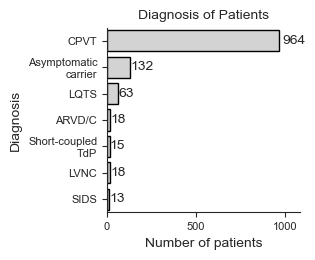

In [22]:
from analysis.database import set_figure_size

# plt.figure(figsize=(2.125 * 2, 2.75 * 2))

fig_2_a = figure_2.panels["panel_a"]

plt.figure(figsize=fig_2_a.fig_size)
ax = sns.barplot(df_diagnoses_g, x="Number of Patients", y="diag_short",
                 color=colors.default_bar, edgecolor="black",
                 orient="h"
                 )

add_bar_labels(ax, ignore_zero=False, direction="horizontal")

# plt.xticks(rotation=60, ha="center")

sns.despine()
# plt.yticks(fontsize=8)
set_figure_size(fig_2_a)

plt.tight_layout()

save_current_plot("primary_diagnosis")

plt.show()